In [395]:
import pandas as pd
import numpy as np
from os import path

# plots
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
%matplotlib inline
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


data_frame = pd.read_csv('data/Entrenamieto_ECI_2020.csv')

In [396]:
data_frame["Opportunity_Created_Date"] = pd.to_datetime(data_frame["Opportunity_Created_Date"], errors="coerce")
data_frame["Planned_Delivery_Start_Date"] = pd.to_datetime(data_frame["Planned_Delivery_Start_Date"], errors="coerce")
data_frame["Planned_Delivery_End_Date"] = pd.to_datetime(data_frame["Planned_Delivery_End_Date"], errors="coerce")
data_frame["Quote_Expiry_Date"] = pd.to_datetime(data_frame["Quote_Expiry_Date"], errors="coerce")
data_frame["Last_Modified_Date"] = pd.to_datetime(data_frame["Last_Modified_Date"], errors="coerce")
data_frame["Account_Created_Date"] = pd.to_datetime(data_frame["Account_Created_Date"], errors="coerce")
#data_frame["Month"] = pd.to_datetime(data_frame["Month"], format = "%Y - %m")

dateColumns = ["Opportunity_Created_Date", "Planned_Delivery_Start_Date", "Planned_Delivery_End_Date", "Quote_Expiry_Date", "Last_Modified_Date", "Account_Created_Date"]

grouped = data_frame.groupby(['Opportunity_Name', 'Opportunity_Created_Date', "Planned_Delivery_Start_Date", "Planned_Delivery_End_Date", "Stage", "Region"]).agg({"Territory": "count"}).reset_index()

In [88]:
#STAGE_POR_RANGO_ENTREGA
grouped = grouped.drop(8401) #Error en rango de entrega
grouped.filter(grouped["Opportunity_Created_Date"] < grouped["Planned_Delivery_Start_Date"])
grouped["delay"] = grouped['Planned_Delivery_Start_Date'].sub(grouped['Opportunity_Created_Date'], axis=0)/ np.timedelta64(1, 'D')
grouped["delay_over_mean"] = grouped["delay"] > grouped["delay"].mean()
grouped.loc[grouped["delay_over_mean"] == True].Stage.value_counts()

,Opportunity_Name,Opportunity_Created_Date,Planned_Delivery_Start_Date,Planned_Delivery_End_Date,Stage,Territory,Month Creation,delay,delay_over_mean
0,Opportunity_Name_0,2016-03-04,2016-06-01,2016-06-30,Closed Lost,1,3,89.0,False
1,Opportunity_Name_0,2016-03-04,2016-07-01,2016-07-31,Closed Lost,1,3,119.0,True
2,Opportunity_Name_0,2016-03-04,2016-08-01,2016-08-31,Closed Lost,1,3,150.0,True
3,Opportunity_Name_0,2016-03-04,2016-09-01,2016-09-30,Closed Lost,1,3,181.0,True
4,Opportunity_Name_0,2016-03-04,2016-10-01,2016-10-31,Closed Lost,1,3,211.0,True


In [4]:
#WIN-RATE POR TERRITORY
closed = data_frame[data_frame["Stage"].str.contains("Closed")]
groupedTerritory = closed.groupby(['Opportunity_Name', "Region", "Territory", "Stage"]).agg({"ID": "count"}).reset_index()
groupedTerritory = groupedTerritory.groupby(["Region", "Stage"]).agg({"ID": "count"})
groupedTerritory = groupedTerritory.pivot_table(columns="Stage", index="Region", values="ID", aggfunc="sum")
groupedTerritory["Closed Won"] = groupedTerritory["Closed Won"].fillna(0)
groupedTerritory["Closed Lost"] = groupedTerritory["Closed Lost"].fillna(0)
groupedTerritory["win_rate_territory"] = groupedTerritory["Closed Won"] / (groupedTerritory["Closed Won"] + groupedTerritory["Closed Lost"])
groupedTerritory.nlargest(20, "win_rate_territory")



Stage,Closed Lost,Closed Won,win_rate_territory
Region,,,
Japan,595,1290,0.684350
APAC,924,1155,0.555556
EMEA,1737,1500,0.463392
Americas,1358,1094,0.446166
Middle East,105,33,0.239130


In [5]:
#TODOS LOS BRAND DISTINTOS DE NONE Y OTHER SON LOST
notNone = data_frame[(data_frame["Brand"] != "None")]
notNone.Stage.value_counts()
#data_frame["Brand"].value_counts()

Closed Lost    1036
Name: Stage, dtype: int64

Text(0, 0.5, 'Win Rate')

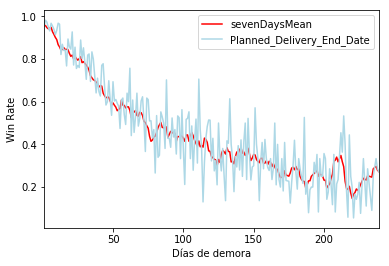

In [6]:
#RELACION WINRATE TIEMPO DEMORA


grouped = grouped[grouped["Opportunity_Created_Date"] < grouped["Planned_Delivery_End_Date"]]
grouped["delay"] = grouped['Planned_Delivery_End_Date'].sub(grouped['Opportunity_Created_Date'], axis=0)/ np.timedelta64(1, 'D')
s = grouped.groupby(["delay", "Stage"]).agg({"Planned_Delivery_End_Date":"count"}).reset_index()
se = s.groupby(["delay"]).apply(lambda x: x[x.Stage=="Closed Won"]['Planned_Delivery_End_Date'] / x['Planned_Delivery_End_Date'].sum()).reset_index()
se = se[se["delay"] < 240]

#PROMEDIO 7 DIAS
meanDelay = []
rangei = 0
rangef = 7
for i in range(len(se["Planned_Delivery_End_Date"])):
    val = 0
    if (rangef > len(se["Planned_Delivery_End_Date"])):
        rangef -= 1
    for j in range (rangei, rangef):
        val += se["Planned_Delivery_End_Date"][j]
    meanDelay.append(val / (rangef - rangei) )
    rangei = rangei + 1
    rangef = rangef + 1

se["sevenDaysMean"] = pd.Series(meanDelay)
ax = se.plot(x='delay', y="sevenDaysMean", kind= "line", color='red')
se.plot(x='delay', y='Planned_Delivery_End_Date', kind= "line", color='lightblue', ax=ax)
ax.set_xlabel("Días de demora")
ax.set_ylabel("Win Rate")

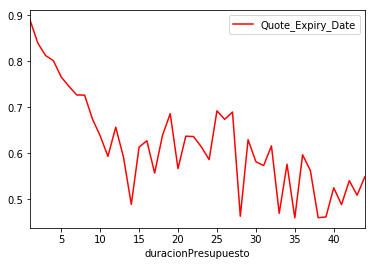

In [7]:
#WINRATE RELACION DURACION PRESUPUESTO

groupedPresupuesto = data_frame.groupby(['Opportunity_Name','Opportunity_Created_Date', 'Quote_Expiry_Date', "Quote_Type", "Stage"]).agg({"Territory": "count"}).reset_index()
groupedPresupuesto = groupedPresupuesto[groupedPresupuesto['Quote_Expiry_Date'] > groupedPresupuesto['Opportunity_Created_Date']]
groupedPresupuesto["duracionPresupuesto"] = groupedPresupuesto['Quote_Expiry_Date'].sub(groupedPresupuesto['Opportunity_Created_Date'], axis=0)/ np.timedelta64(1, 'D')


s1 = groupedPresupuesto.groupby(["duracionPresupuesto", "Stage"]).agg({"Quote_Expiry_Date":"count"}).reset_index()
se2 = s1.groupby(["duracionPresupuesto"]).apply(lambda x: x[x.Stage=="Closed Won"]['Quote_Expiry_Date'] / x['Quote_Expiry_Date'].sum()).reset_index()
se2 = se2[se2["duracionPresupuesto"] < 45]

se2.plot(x='duracionPresupuesto', y="Quote_Expiry_Date", kind= "line", color='red')


In [8]:
#PRODUCTOS POR OPORTUNIDAD // QUOTE TYPE

productsByOpportunity = data_frame.groupby(['Opportunity_Name', 'Stage']).agg({"ID":"count"}).reset_index()
productsByOpportunity.columns = ["Opportunity_Name", "Resultado", "Cantidad"]
productsByOpportunity.groupby("Cantidad")

data_frame.Quote_Expiry_Date.isnull().value_counts()
data_frame[data_frame["Quote_Type"] == "Binding"].Stage.value_counts()


Closed Won     86
Closed Lost    84
Name: Stage, dtype: int64

In [369]:
#RELACION WIN RATE CON MESES EN LA PLATAFORMA

correctDates = data_frame.drop_duplicates(subset=["Opportunity_Name"])
correctDates = data_frame[data_frame["Account_Created_Date"] <= data_frame["Opportunity_Created_Date"]]
correctDates["monthsInSystemBeforeOpportunity"] = np.floor(correctDates["Opportunity_Created_Date"].sub(correctDates["Account_Created_Date"], axis=0)/ np.timedelta64(1, 'M'))

grp = correctDates.groupby(["monthsInSystemBeforeOpportunity", "Stage"]).agg({"ID": "count"}).reset_index()
grp = grp.groupby(["monthsInSystemBeforeOpportunity"]).apply(lambda x: len(x[x.Stage=="Closed Won"]) / len(x)).reset_index()
grp.columns = ["monthsInSystemBeforeOpportunity", "winRate"]

(0, 1)

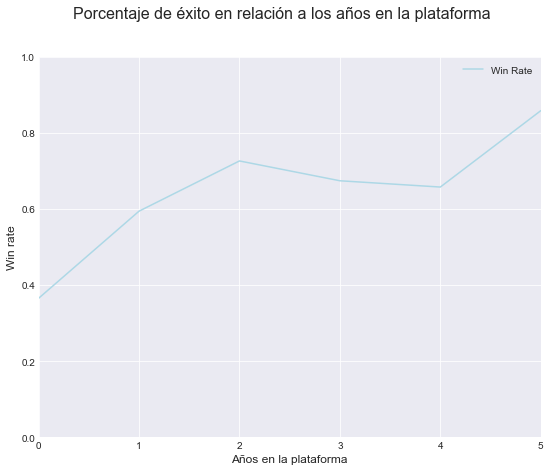

In [373]:
#RELACION WIN RATE CON MESES EN LA PLATAFORMA

correctDates = data_frame.drop_duplicates(subset=["Opportunity_Name"])
correctDates = data_frame[data_frame["Account_Created_Date"] <= data_frame["Opportunity_Created_Date"]]
correctDates["monthsInSystemBeforeOpportunity"] = np.floor(correctDates["Opportunity_Created_Date"].sub(correctDates["Account_Created_Date"], axis=0)/ np.timedelta64(1, 'Y'))

grp = correctDates.groupby(["monthsInSystemBeforeOpportunity", "Stage"]).agg({"ID": "count"}).reset_index()
grp = grp.groupby(["monthsInSystemBeforeOpportunity"]).apply(lambda x: x[x.Stage=="Closed Won"]['ID'] / x['ID'].sum()).reset_index()
grp.columns = ["monthsInSystemBeforeOpportunity", "Count", "winRate"]


ax = grp.plot(x="monthsInSystemBeforeOpportunity", y="winRate",color="lightblue", kind="line", figsize=(9,7))

plt.suptitle("Porcentaje de éxito en relación a los años en la plataforma", size=16)
ax.legend(["Win Rate", "Promedio (7 días)"])
ax.set_xlabel("Años en la plataforma", size=12)
ax.set_ylabel("Win rate", size=12)
ax.set_ylim([0,1])

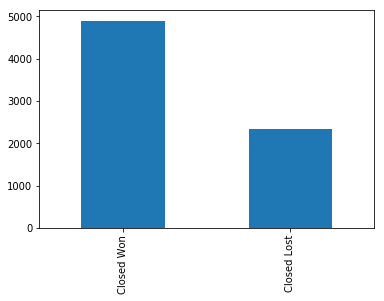

In [27]:
#RANGO DE DELIVERY
endAfterStart = data_frame[data_frame["Planned_Delivery_End_Date"] >= data_frame["Planned_Delivery_Start_Date"]]
endAfterStart["Delivery_Range"] = endAfterStart["Planned_Delivery_End_Date"].sub(data_frame["Planned_Delivery_Start_Date"], axis=0)/ np.timedelta64(1, 'D')
closedOpportunities = endAfterStart[endAfterStart["Stage"].str.contains("Closed")]
#largestDeliveryRange = data_frame[closedOpportunities["Delivery_Range"] > 0]
#largestDeliveryRange.Stage.value_counts().plot.bar()

smallestDeliveryRange = closedOpportunities[closedOpportunities["Delivery_Range"] == 0]
smallestDeliveryRange.Stage.value_counts().plot.bar()

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


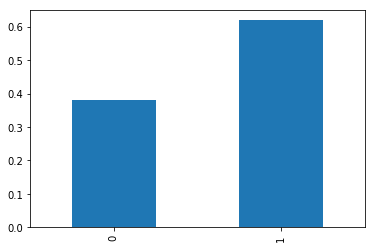

In [29]:
#WINRATE EN VENTAS CON Y SIN "ENVIO RAPIDO"
#ENVIO RAPIDO = Articulo con demora máxima menor a 7 días.

EndAfterStart = data_frame[data_frame["Planned_Delivery_End_Date"] > data_frame["Planned_Delivery_Start_Date"]]
closedOpportunities = EndAfterStart[EndAfterStart["Stage"].str.contains("Closed")]
closedOpportunities["Delivery_Range"] = closedOpportunities["Planned_Delivery_End_Date"].sub(closedOpportunities["Planned_Delivery_Start_Date"], axis=0)/ np.timedelta64(1, 'D')
stageDelivery = closedOpportunities.groupby(["Opportunity_ID", "Stage"]).agg({"Delivery_Range": "max"}).reset_index()
stageDelivery["Fast_Delivery"] = stageDelivery["Delivery_Range"] < 7
winRateByFastDelivery = stageDelivery.groupby("Fast_Delivery").apply(lambda x: len(x[x.Stage=="Closed Won"]) / len(x)).reset_index()
winRateByFastDelivery.columns = ["Fast_Delivery", "Winrate"]
winRateByFastDelivery["Winrate"].plot.bar()


In [31]:
opportunitiesBySeller = data_frame.groupby(["Opportunity_Owner"]).agg({"Opportunity_ID": pd.Series.nunique})
#opportunitiesBySeller.nlargest(10, "Opportunity_ID").plot.barh()
taxableAmount = data_frame.groupby(["Opportunity_Name", "Opportunity_Owner", "Total_Taxable_Amount", "Stage"]).agg({"Opportunity_ID": pd.Series.nunique}).reset_index()
meanAmountBySeller = taxableAmount.groupby("Opportunity_Owner").agg({"Total_Taxable_Amount": "mean", "Opportunity_ID":"count"}).reset_index()

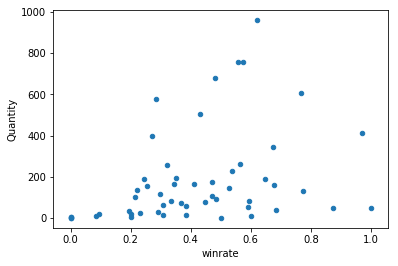

In [32]:
#VENDEDORES: WINRATE vs CANTIDAD DE VENTAS
winRateBySeller = taxableAmount.groupby(["Opportunity_Owner"]).apply(lambda x: len(x[x.Stage=="Closed Won"]) / len(x)).reset_index()

merged = winRateBySeller.merge(meanAmountBySeller, on="Opportunity_Owner")
merged.columns = ['Opportunity_Owner', "winrate", 'Total_Taxable_Amount', 'Quantity']
merged.plot(x="winrate", y="Quantity", kind="scatter")

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


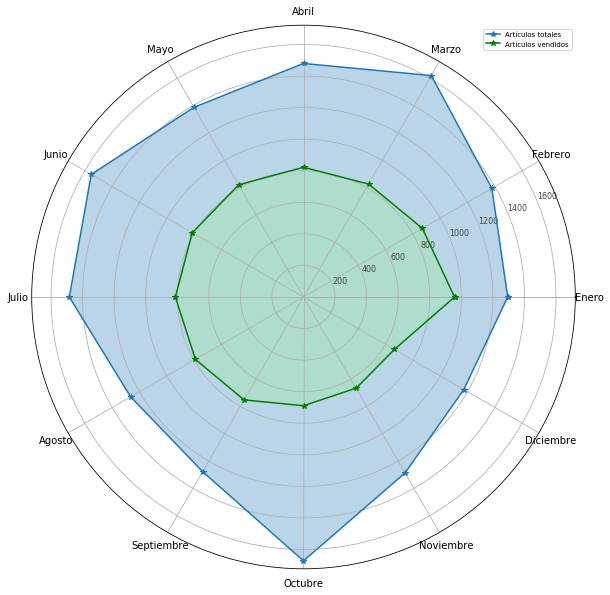

In [55]:
#MES DE ENVIO DEL ARTICULO.

monthName = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio", "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"]

data_frame["Month Delivery"] = data_frame["Month"].apply(lambda x: int(x.month))
deliverysByMonth = data_frame.groupby("Month Delivery").agg({"Month":"count"}).reset_index()

angulos = [n / float(12) * 2 * np.pi for n in range(12)]
angulos += angulos[:1]

deliverysList = list(deliverysByMonth["Month"])
deliverysList += deliverysList[:1]

plt.figure(figsize=(10,10))
plt.polar(angulos, deliverysList, marker="*")
plt.fill(angulos, deliverysList, alpha=0.3)
plt.xticks(angulos, monthName)

plt.yticks(size=8, color="#484545")


winsByMonth = data_frame[data_frame["Stage"] == "Closed Won"]

winsByMonth["Month Delivery"] = winsByMonth["Month"].apply(lambda x: int(x.month))
winsByMonth = winsByMonth["Month Delivery"].value_counts().reset_index()

deliverysWonList = list(winsByMonth["Month Delivery"])
deliverysWonList += deliverysWonList[:1]

plt.polar(angulos, deliverysWonList, marker="*", color="green")
plt.fill(angulos, deliverysWonList, alpha=0.3, color="lightgreen")

plt.legend(["Artículos totales", "Artículos vendidos"], fontsize="x-small")
plt.show()


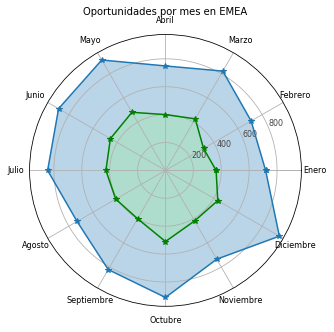

In [190]:
#MES CREACION OPORTUNIDADES
monthName = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio", "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"]

grouped["Month Creation"] = grouped["Opportunity_Created_Date"].apply(lambda x: int(x.month))
grouped = grouped.drop_duplicates(subset=["Opportunity_Name"])
grouped.loc[grouped["Region"]=="EMEA"]

groupedWon = grouped[grouped["Stage"] == "Closed Won"]
groupedWon["Month Creation"] = groupedWon["Opportunity_Created_Date"].apply(lambda x: int(x.month))

total = grouped["Month Creation"].value_counts().reset_index().sort_values(by="index")
wonByMonth = groupedWon["Month Creation"].value_counts().reset_index().sort_values(by="index")


#GRAFICO
angulos = [n / float(12) * 2 * np.pi for n in range(12)]
angulos += angulos[:1]

#Agrego el primer valor al final para cerrar el ciclo
totalList = list(total["Month Creation"])
totalList += totalList[:1]
wonList = list(wonByMonth["Month Creation"])
wonList += wonList[:1]

plt.figure(figsize=(5,5))
plt.polar(angulos, totalList, marker="*")
plt.fill(angulos, totalList, alpha=0.3)
plt.polar(angulos, wonList, marker="*", color="green")
plt.fill(angulos, wonList, alpha=0.3, color="lightgreen")

plt.xticks(angulos, monthName, size=8)
plt.yticks(size=8, color="#484545")

plt.title("Oportunidades por mes en EMEA", size=10)
#plt.legend(["Oportunidades totales", "Oportunidades ganadas"], fontsize="xx-small")
plt.show()


Text(0, 0.5, 'Cantidad de oportunidades')

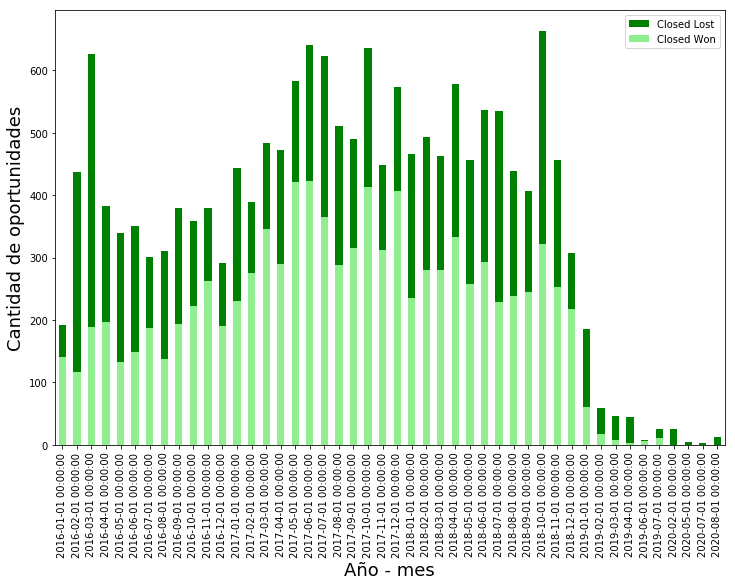

In [57]:
#ARTICULOS POR MES

#TODO: agregar barras vacías
data_frame.loc[data_frame.Stage.str.contains("Closed")]
opportunitiesByMonth = data_frame["Month"].value_counts().reset_index()

#AGREGO MESES FALTANTES
opportunitiesByMonth.loc[opportunitiesByMonth.shape[0]] = [pd.to_datetime("2020-02-01"), 0]
opportunitiesByMonth.loc[opportunitiesByMonth.shape[0]+1] = [pd.to_datetime("2020-05-01"), 0]
opportunitiesByMonth.loc[opportunitiesByMonth.shape[0]+2] = [pd.to_datetime("2020-07-01"), 0]
opportunitiesByMonth.loc[opportunitiesByMonth.shape[0]+3] = [pd.to_datetime("2020-08-01"), 0]

ax = opportunitiesByMonth.sort_values(by="index").plot.bar(x = "index", figsize=(16,12), color = "green")


opportunitiesWonByMonth = data_frame[data_frame["Stage"] == "Closed Won"]["Month"].value_counts().reset_index()

#AGREGO MESES FALTANTES
opportunitiesWonByMonth.loc[opportunitiesWonByMonth.shape[0]] = [pd.to_datetime("2020-02-01"), 0]
opportunitiesWonByMonth.loc[opportunitiesWonByMonth.shape[0]+1] = [pd.to_datetime("2020-05-01"), 0]
opportunitiesWonByMonth.loc[opportunitiesWonByMonth.shape[0]+2] = [pd.to_datetime("2020-07-01"), 0]
opportunitiesWonByMonth.loc[opportunitiesWonByMonth.shape[0]+3] = [pd.to_datetime("2020-08-01"), 0]

opportunitiesWonByMonth.sort_values(by="index").plot.bar(x = "index", figsize=(12,8), ax = ax, color = "lightgreen")

ax.legend(["Closed Lost", "Closed Won"])
ax.set_xlabel("Año - mes", fontsize=18)
ax.set_ylabel("Cantidad de artículos", fontsize=18)

Text(0, 0.5, 'Cantidad de oportunidades')

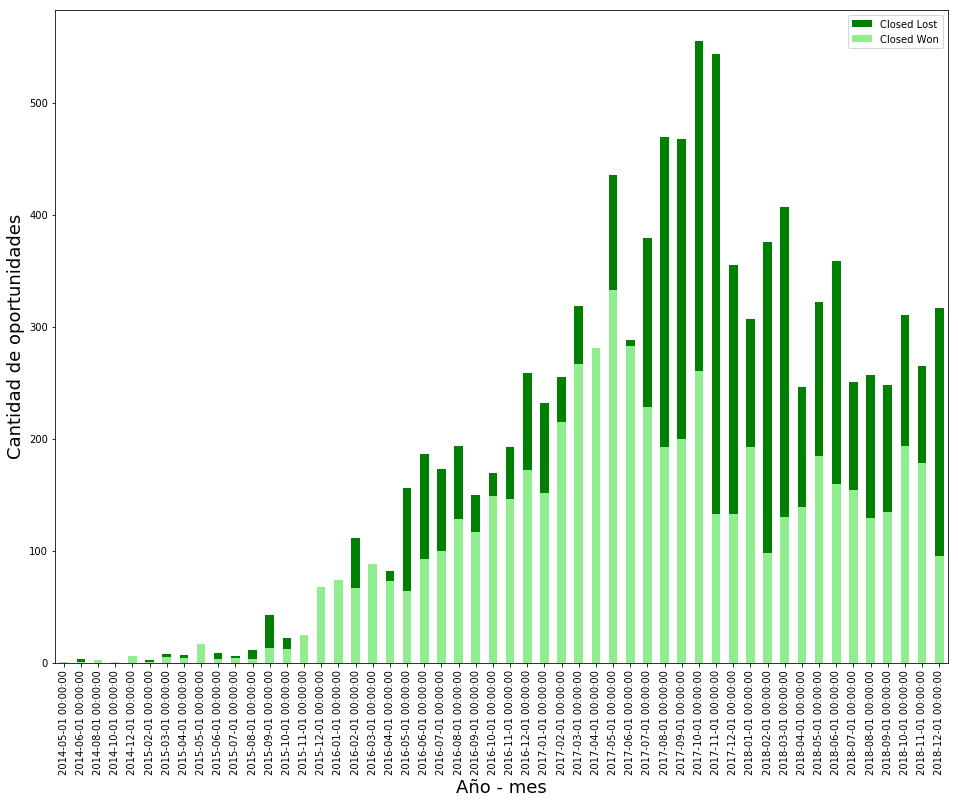

In [61]:
#OPORTUNIDADES POR MES
#TODO: agregar meses vacíos.
grouped["Month Creation"] = grouped["Opportunity_Created_Date"].apply(lambda x: str(x.year) + " - " + str(x.month))
grouped["Month Creation"] = pd.to_datetime(grouped["Month Creation"], format = "%Y - %m")

ax = grouped["Month Creation"].value_counts().reset_index().sort_values(by="index").plot.bar(x = "index", figsize=(16,12), color = "green")

grouped[grouped["Stage"] == "Closed Won"]["Month Creation"].value_counts().reset_index().sort_values(by="index").plot.bar(x = "index", figsize=(16,12), ax = ax, color = "lightgreen")

ax.legend(["Closed Lost", "Closed Won"])
ax.set_xlabel("Año - mes", fontsize=18)
ax.set_ylabel("Cantidad de oportunidades", fontsize=18)

In [92]:
data_frame.groupby("Opportunity_ID").agg({"ID":"count"})
len(grouped)

11295

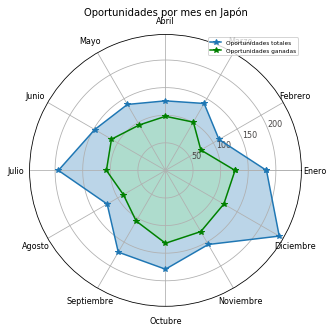

In [191]:
#MES CREACION OPORTUNIDADES JAPON
monthName = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio", "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"]

grouped = data_frame.groupby(["Opportunity_Name", "Opportunity_Created_Date", "Stage", "Region"]).agg({"ID":"count"}).reset_index()
grouped["Month Creation"] = grouped["Opportunity_Created_Date"].apply(lambda x: int(x.month))
grouped = grouped.drop_duplicates(subset=["Opportunity_Name"])
grouped = grouped.loc[grouped["Region"]=="Japan"]

groupedWon = grouped[grouped["Stage"] == "Closed Won"]
groupedWon["Month Creation"] = groupedWon["Opportunity_Created_Date"].apply(lambda x: int(x.month))

total = grouped["Month Creation"].value_counts().reset_index().sort_values(by="index")
wonByMonth = groupedWon["Month Creation"].value_counts().reset_index().sort_values(by="index")


#GRAFICO
angulos = [n / float(12) * 2 * np.pi for n in range(12)]
angulos += angulos[:1]

#Agrego el primer valor al final para cerrar el ciclo
totalList = list(total["Month Creation"])
totalList += totalList[:1]
wonList = list(wonByMonth["Month Creation"])
wonList += wonList[:1]

plt.figure(figsize=(5,5))
plt.polar(angulos, totalList, marker="*")
plt.fill(angulos, totalList, alpha=0.3)
plt.polar(angulos, wonList, marker="*", color="green")
plt.fill(angulos, wonList, alpha=0.3, color="lightgreen")

plt.xticks(angulos, monthName, size=8)
plt.yticks(size=8, color="#484545")

plt.title("Oportunidades por mes en Japón", size=10)
plt.legend(["Oportunidades totales", "Oportunidades ganadas"], fontsize="xx-small")
plt.show()

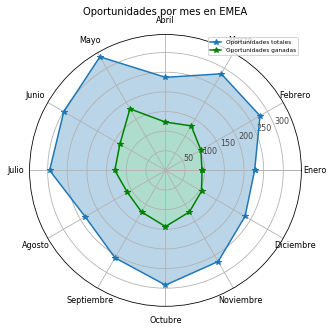

In [192]:
#MES CREACION OPORTUNIDADES EMEA
monthName = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio", "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"]

grouped = data_frame.groupby(["Opportunity_Name", "Opportunity_Created_Date", "Stage", "Region"]).agg({"ID":"count"}).reset_index()
grouped["Month Creation"] = grouped["Opportunity_Created_Date"].apply(lambda x: int(x.month))
grouped = grouped.drop_duplicates(subset=["Opportunity_Name"])
grouped = grouped.loc[grouped["Region"]=="EMEA"]

groupedWon = grouped[grouped["Stage"] == "Closed Won"]
groupedWon["Month Creation"] = groupedWon["Opportunity_Created_Date"].apply(lambda x: int(x.month))

total = grouped["Month Creation"].value_counts().reset_index().sort_values(by="index")
wonByMonth = groupedWon["Month Creation"].value_counts().reset_index().sort_values(by="index")


#GRAFICO
angulos = [n / float(12) * 2 * np.pi for n in range(12)]
angulos += angulos[:1]

#Agrego el primer valor al final para cerrar el ciclo
totalList = list(total["Month Creation"])
totalList += totalList[:1]
wonList = list(wonByMonth["Month Creation"])
wonList += wonList[:1]

plt.figure(figsize=(5,5))
plt.polar(angulos, totalList, marker="*")
plt.fill(angulos, totalList, alpha=0.3)
plt.polar(angulos, wonList, marker="*", color="green")
plt.fill(angulos, wonList, alpha=0.3, color="lightgreen")

plt.xticks(angulos, monthName, size=8)
plt.yticks(size=8, color="#484545")

plt.title("Oportunidades por mes en EMEA", size=10)
plt.legend(["Oportunidades totales", "Oportunidades ganadas"], fontsize="xx-small")
plt.show()

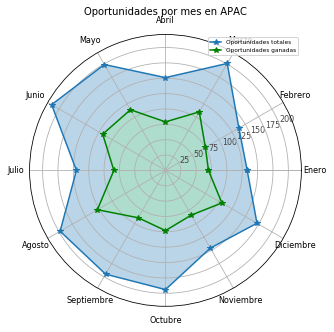

In [196]:
#MES CREACION OPORTUNIDADES APAC
monthName = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio", "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"]

grouped = data_frame.groupby(["Opportunity_Name", "Opportunity_Created_Date", "Stage", "Region"]).agg({"ID":"count"}).reset_index()
grouped["Month Creation"] = grouped["Opportunity_Created_Date"].apply(lambda x: int(x.month))
grouped = grouped.drop_duplicates(subset=["Opportunity_Name"])
grouped = grouped.loc[grouped["Region"]=="APAC"]

groupedWon = grouped[grouped["Stage"] == "Closed Won"]
groupedWon["Month Creation"] = groupedWon["Opportunity_Created_Date"].apply(lambda x: int(x.month))

total = grouped["Month Creation"].value_counts().reset_index().sort_values(by="index")
wonByMonth = groupedWon["Month Creation"].value_counts().reset_index().sort_values(by="index")


#GRAFICO
angulos = [n / float(12) * 2 * np.pi for n in range(12)]
angulos += angulos[:1]

#Agrego el primer valor al final para cerrar el ciclo
totalList = list(total["Month Creation"])
totalList += totalList[:1]
wonList = list(wonByMonth["Month Creation"])
wonList += wonList[:1]

plt.figure(figsize=(5,5))
plt.polar(angulos, totalList, marker="*")
plt.fill(angulos, totalList, alpha=0.3)
plt.polar(angulos, wonList, marker="*", color="green")
plt.fill(angulos, wonList, alpha=0.3, color="lightgreen")

plt.xticks(angulos, monthName, size=8)
plt.yticks(size=8, color="#484545")

plt.title("Oportunidades por mes en APAC", size=10)
plt.legend(["Oportunidades totales", "Oportunidades ganadas"], fontsize="xx-small")
plt.show()

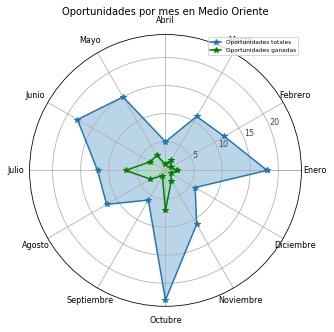

In [194]:
#MES CREACION OPORTUNIDADES MIDDLE EAST
monthName = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio", "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"]

grouped = data_frame.groupby(["Opportunity_Name", "Opportunity_Created_Date", "Stage", "Region"]).agg({"ID":"count"}).reset_index()
grouped["Month Creation"] = grouped["Opportunity_Created_Date"].apply(lambda x: int(x.month))
grouped = grouped.drop_duplicates(subset=["Opportunity_Name"])
grouped = grouped.loc[grouped["Region"]=="Middle East"]

groupedWon = grouped[grouped["Stage"] == "Closed Won"]
groupedWon["Month Creation"] = groupedWon["Opportunity_Created_Date"].apply(lambda x: int(x.month))

total = grouped["Month Creation"].value_counts().reset_index().sort_values(by="index")
wonByMonth = groupedWon["Month Creation"].value_counts().reset_index().sort_values(by="index")


#GRAFICO
angulos = [n / float(12) * 2 * np.pi for n in range(12)]
angulos += angulos[:1]

#Agrego el primer valor al final para cerrar el ciclo
totalList = list(total["Month Creation"])
totalList += totalList[:1]
wonList = list(wonByMonth["Month Creation"])
wonList += wonList[:1]

plt.figure(figsize=(5,5))
plt.polar(angulos, totalList, marker="*")
plt.fill(angulos, totalList, alpha=0.3)
plt.polar(angulos, wonList, marker="*", color="green")
plt.fill(angulos, wonList, alpha=0.3, color="lightgreen")

plt.xticks(angulos, monthName, size=8)
plt.yticks(size=8, color="#484545")

plt.title("Oportunidades por mes en Medio Oriente", size=10)
plt.legend(["Oportunidades totales", "Oportunidades ganadas"], fontsize="xx-small")
plt.show()

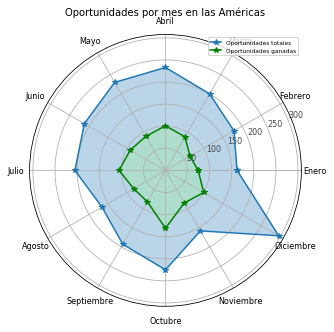

In [195]:
#MES CREACION OPORTUNIDADES LAS AMERICAS
monthName = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio", "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"]

grouped = data_frame.groupby(["Opportunity_Name", "Opportunity_Created_Date", "Stage", "Region"]).agg({"ID":"count"}).reset_index()
grouped["Month Creation"] = grouped["Opportunity_Created_Date"].apply(lambda x: int(x.month))
grouped = grouped.drop_duplicates(subset=["Opportunity_Name"])
grouped = grouped.loc[grouped["Region"]=="Americas"]

groupedWon = grouped[grouped["Stage"] == "Closed Won"]
groupedWon["Month Creation"] = groupedWon["Opportunity_Created_Date"].apply(lambda x: int(x.month))

total = grouped["Month Creation"].value_counts().reset_index().sort_values(by="index")
wonByMonth = groupedWon["Month Creation"].value_counts().reset_index().sort_values(by="index")


#GRAFICO
angulos = [n / float(12) * 2 * np.pi for n in range(12)]
angulos += angulos[:1]

#Agrego el primer valor al final para cerrar el ciclo
totalList = list(total["Month Creation"])
totalList += totalList[:1]
wonList = list(wonByMonth["Month Creation"])
wonList += wonList[:1]

plt.figure(figsize=(5,5))
plt.polar(angulos, totalList, marker="*")
plt.fill(angulos, totalList, alpha=0.3)
plt.polar(angulos, wonList, marker="*", color="green")
plt.fill(angulos, wonList, alpha=0.3, color="lightgreen")

plt.xticks(angulos, monthName, size=8)
plt.yticks(size=8, color="#484545")

plt.title("Oportunidades por mes en las Américas", size=10)
plt.legend(["Oportunidades totales", "Oportunidades ganadas"], fontsize="xx-small")
plt.show()

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\matplotlib\axes\_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\matplotlib\axes\_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


(0, 1)

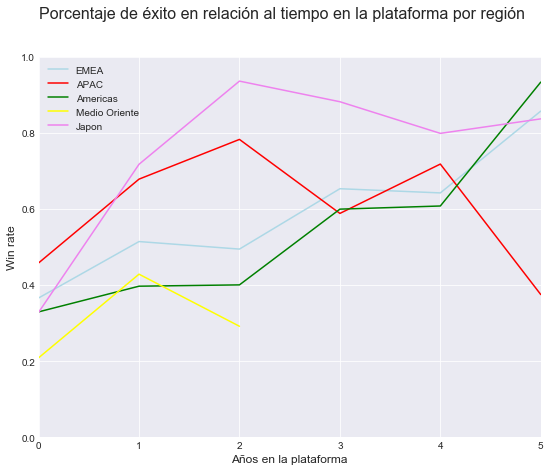

In [301]:
#RELACION WIN RATE CON AÑOS EN LA PLATAFORMA

correctDates = data_frame.drop_duplicates(subset=["Opportunity_Name"])
correctDates = data_frame[data_frame["Account_Created_Date"] <= data_frame["Opportunity_Created_Date"]]
correctDates["monthsInSystemBeforeOpportunity"] = np.floor(correctDates["Opportunity_Created_Date"].sub(correctDates["Account_Created_Date"], axis=0)/ np.timedelta64(1, 'Y'))

grp = correctDates.groupby(["monthsInSystemBeforeOpportunity", "Stage", "Region"]).agg({"ID": "count"}).reset_index()
grp = grp.groupby(["monthsInSystemBeforeOpportunity", "Region"]).apply(lambda x: x[x.Stage=="Closed Won"]['ID'] / x['ID'].sum()).reset_index()
grp.columns = ["monthsInSystemBeforeOpportunity", "Region", "Count", "winRate"]

EMEA = grp.loc[grp["Region"]=="EMEA"]
ax = EMEA.plot(x="monthsInSystemBeforeOpportunity", y="winRate",color="lightblue", kind="line", figsize=(9,7))

APAC = grp.loc[grp["Region"]=="APAC"]
APAC.plot(x="monthsInSystemBeforeOpportunity", y="winRate", kind="line", ax=ax, color="red")

AMERICAS = grp.loc[grp["Region"]=="Americas"]
AMERICAS.plot(x="monthsInSystemBeforeOpportunity", y="winRate", kind="line", ax=ax, color="green")

MIDDLEEAST = grp.loc[grp["Region"]=="Middle East"]
MIDDLEEAST.plot(x="monthsInSystemBeforeOpportunity", y="winRate", kind="line", ax=ax, color="yellow")

JAPAN = grp.loc[grp["Region"]=="Japan"]
JAPAN.plot(x="monthsInSystemBeforeOpportunity", y="winRate", kind="line", ax=ax, color="violet")

#grp.plot(x="monthsInSystemBeforeOpportunity", y="sevenDaysMean", kind="line", ax=ax, color="red")

plt.suptitle("Porcentaje de éxito en relación al tiempo en la plataforma por región", size=16)
ax.legend(["EMEA", "APAC", "Americas", "Medio Oriente", "Japon"])
ax.set_xlabel("Años en la plataforma", size=12)
ax.set_ylabel("Win rate", size=12)
ax.set_ylim(ymin=0, ymax=1)

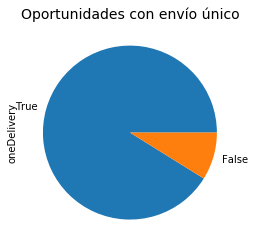

In [265]:
#DURACION TOTAL DE OPORTUNIDAD

#PRIMERO ANALISIS DE OPORTUNIDADES CON UNA SOLA FECHA DE ENVIO. ALGUNAS OPORTUNIDADES CON MÁS ARTÍCULOS TIENEN DISTINTAS FECHAS DE ENVÍO
#TODOS LOS PRODUCTOS DE LA OPORTUNIDAD SE ENVIAN AL MISMO TIEMPO

g = data_frame.groupby("Opportunity_Name").agg({"Planned_Delivery_End_Date":pd.Series.nunique, "ID":"count"}).reset_index()
g["oneDelivery"] = g["Planned_Delivery_End_Date"] == 1
ax = g["oneDelivery"].value_counts().plot.pie()
ax.set_title("Oportunidades con envío único", size=14)

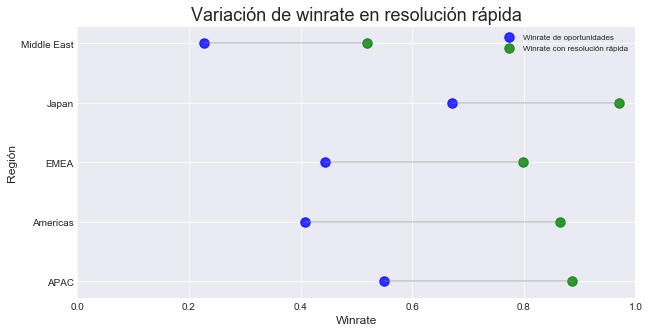

In [385]:
#DENTRO DE LAS OPORTUNIDADES CON ENVÍO ÚNICO, COMO VARÍA EL WINRATE SEGÚN EL TIEMPO DE ENVÍO?

g = g[g["oneDelivery"]]
onlyOneDelivery = data_frame.merge(g, on="Opportunity_Name")
onlyOneDelivery.Opportunity_Name.value_counts()
onlyOneDelivery = onlyOneDelivery.drop_duplicates(subset=["Opportunity_Name"])
onlyOneDelivery = onlyOneDelivery[onlyOneDelivery['Planned_Delivery_Start_Date'] >= onlyOneDelivery['Opportunity_Created_Date']]

onlyOneDelivery["deliveryDelay"] = onlyOneDelivery['Planned_Delivery_Start_Date'].sub(onlyOneDelivery['Opportunity_Created_Date'], axis=0)/ np.timedelta64(1, 'D')

#DEFINO RESOLUCION RAPIDA SI ES MENOR A 14 DIAS

onlyOneDelivery.Region.value_counts()
fastDelivery = onlyOneDelivery[onlyOneDelivery["deliveryDelay"] <= 14]

winRateFastDelivery = fastDelivery.groupby(["Region", "Stage"]).agg({"Opportunity_ID":"count"}).reset_index()
winRateFastDelivery = winRateFastDelivery.groupby("Region").apply(lambda x: x[x["Stage"]=="Closed Won"]["Opportunity_ID"]/x["Opportunity_ID"].sum()).reset_index()

oneDeliveryByRegion = onlyOneDelivery.groupby(["Region", "Stage"]).agg({"Opportunity_ID":"count"}).reset_index()
winRateByRegion = oneDeliveryByRegion.groupby("Region").apply(lambda x: x[x["Stage"]=="Closed Won"]["Opportunity_ID"]/x["Opportunity_ID"].sum()).reset_index()

merged = winRateByRegion.merge(winRateFastDelivery, on="Region")

plt.figure(figsize=(10,5))
plt.scatter(merged['Opportunity_ID_x'], merged["Region"], color='blue', alpha=0.8, label='value1', s=90)
plt.scatter(merged['Opportunity_ID_y'], merged["Region"], color='green', alpha=0.8 , label='value2', s=90)
plt.hlines(y=merged["Region"], xmin=merged['Opportunity_ID_x'], xmax=merged['Opportunity_ID_y'], color='grey', alpha=0.4)
axes = plt.gca()
axes.set_xlim([0,1])
plt.title("Variación de winrate en resolución rápida", size=18)
plt.xlabel("Winrate", size=12)
plt.ylabel("Región", size=12)
plt.legend(["Winrate de oportunidades", "Winrate con resolución rápida"], prop={'size': 8})


Text(0, 0.5, 'Región')

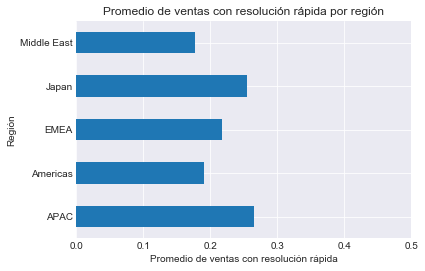

In [499]:
ax = ((fastDelivery.Region.value_counts())/(onlyOneDelivery.Region.value_counts())).plot.barh()
ax.set_xlim([0,0.5])
ax.set_title("Promedio de ventas con resolución rápida por región")
ax.set_xlabel("Promedio de ventas con resolución rápida")
ax.set_ylabel("Región")

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


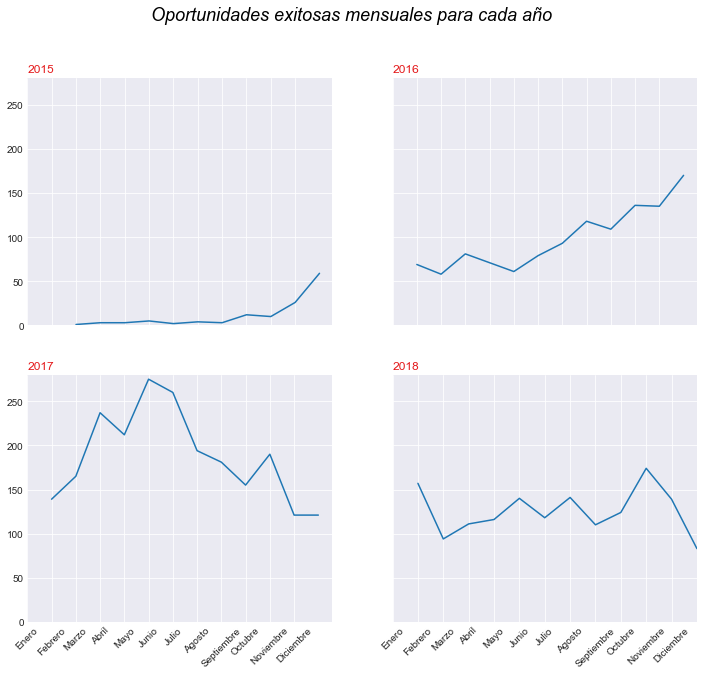

In [474]:
monthName = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio", "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"]

plt.figure(figsize=(12,10))

año2015 = data_frame.loc[(data_frame["Opportunity_Created_Date"].dt.year == 2015) & (data_frame["Stage"] == "Closed Won"),:]
año2015["mesCreacion"] = data_frame["Opportunity_Created_Date"].dt.month
opPorMes2 = año2015.groupby("mesCreacion").agg({"Opportunity_ID": pd.Series.nunique}).reset_index()
plt.subplot(2,2, 1)
plt.ylim(0,280)
plt.plot(opPorMes2["mesCreacion"], opPorMes2["Opportunity_ID"])
plt.xticks(np.arange(12), monthName, rotation=45)
plt.tick_params(labelbottom='off')
plt.title(2015, loc='left', fontsize=12, fontweight=0, color=palette(num) )


año2016 = data_frame.loc[(data_frame["Opportunity_Created_Date"].dt.year == 2016) & (data_frame["Stage"] == "Closed Won"),:]
año2016["mesCreacion"] = data_frame["Opportunity_Created_Date"].dt.month
opPorMes3 = año2016.groupby("mesCreacion").agg({"Opportunity_ID": pd.Series.nunique}).reset_index()
plt.subplot(2,2, 2)
plt.ylim(0,280)
plt.plot(opPorMes3["mesCreacion"], opPorMes3["Opportunity_ID"])
plt.xticks(np.arange(12), monthName, rotation=45)
plt.tick_params(labelbottom='off', labelleft='off')
plt.title(2016, loc='left', fontsize=12, fontweight=0, color=palette(num) )


año2017 = data_frame.loc[(data_frame["Opportunity_Created_Date"].dt.year == 2017) & (data_frame["Stage"] == "Closed Won"),:]
año2017["mesCreacion"] = data_frame["Opportunity_Created_Date"].dt.month
opPorMes4 = año2017.groupby("mesCreacion").agg({"Opportunity_ID": pd.Series.nunique}).reset_index()
plt.subplot(2,2, 3)
plt.ylim(0,280)
plt.plot(opPorMes4["mesCreacion"], opPorMes4["Opportunity_ID"])
plt.title(2017, loc='left', fontsize=12, fontweight=0, color=palette(num) )
plt.xticks(np.arange(12), monthName, rotation=45)


año2018 = data_frame.loc[(data_frame["Opportunity_Created_Date"].dt.year == 2018) & (data_frame["Stage"] == "Closed Won"),:]
año2018["mesCreacion"] = data_frame["Opportunity_Created_Date"].dt.month
opPorMes5 = año2018.groupby("mesCreacion").agg({"Opportunity_ID": pd.Series.nunique}).reset_index()
plt.subplot(2,2, 4)
plt.xlim(1, 12)
plt.ylim(0,280)
plt.plot(opPorMes5["mesCreacion"], opPorMes5["Opportunity_ID"])
plt.tick_params(labelleft='off')
plt.title(2018, loc='left', fontsize=12, fontweight=0, color=palette(num))
plt.xticks(np.arange(12), monthName, rotation=45)

plt.suptitle("Oportunidades exitosas mensuales para cada año", fontsize=18, color='black', style='italic')


plt.show()

